# Variance Reduction in Stochastic Gradient Descent

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.nn import softmax
%tensorflow_version 2.x

## Data Preprocessing

In [ ]:
def get_mnist_data(n_train, n_test):
    (X_train, y_train), (X_test, y_test) =  tf.keras.datasets.mnist.load_data()

    p = np.random.permutation(len(X_train))
    idx = np.random.choice(p, n_train)
    X_train, y_train = X_train[idx], y_train[idx]

    p = np.random.permutation(len(X_test))
    idx = np.random.choice(p, n_test)
    X_test, y_test = X_test[idx], y_test[idx]

    X_train, X_test = np.array(X_train, np.float32), np.array(X_test, np.float32)
    X_train, X_test = X_train.reshape([n_train, 784]), X_test.reshape([n_test, 784])

    return (X_train / 255., y_train), (X_test / 255., y_test)

In [ ]:
M = 6000
(X_train, y_train), (X_test, y_test) = get_mnist_data(M, 1000)

11493376/11490434 [==============================] - 0s 0us/step


## Model Definition

In [ ]:
class MNIST_Model():
    def __init__(self, n_features = 784, n_classes = 10):
        self.n_features = n_features
        self.n_classes = n_classes
        self.W = tf.Variable(tf.ones([n_features, n_classes]), dtype = tf.float32)
        self.b = tf.Variable(tf.zeros([n_classes]))

    @tf.function
    def predict(self, X):
        return softmax(tf.matmul(X, self.W) + self.b)
    
    @tf.function
    def loss(self, X, y, gamma):
        y = tf.one_hot(y, depth=self.n_classes)
        y_hat = tf.clip_by_value(self.predict(X), 1e-9, 1.)
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.math.log(y_hat)))
        reg = tf.reduce_sum(tf.multiply(self.W, self.W)) + tf.reduce_sum(tf.multiply(self.b, self.b))
        return cross_entropy + gamma*reg / 2

    def accuracy(self, X, y):
        y_hat = self.predict(X)
        correct_prediction = tf.equal(tf.argmax(y_hat, 1), tf.cast(y, tf.int64))
        return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

    @tf.function
    def gradients(self, X, y, gamma):
        with tf.GradientTape() as tape:
            loss = self.loss(X, y, gamma)
        return tape.gradient(loss, [self.W, self.b])

    def gradient_descent(self, X, y, gamma, optimizer):
        grads = self.gradients(X, y, gamma)
        optimizer.apply_gradients(zip(grads, [self.W, self.b]))
        return grads

    def SVRG(self, X, y, gamma, g_W, g_b, mu_W, mu_b, optimizer):
        grads_W, grads_b = self.gradients(X, y, gamma)
        delta_W = grads_W - g_W + mu_W
        delta_b = grads_b - g_b + mu_b
        optimizer.apply_gradients(zip([delta_W, delta_b], [self.W, self.b]))
        return delta_W, delta_b

## Stochastic Gradient Descent

In [ ]:
def compute_variance(grads):
    gW, gb = map(list, zip(*grads))
    return tf.reduce_sum(tf.math.reduce_variance(gW, 0)) + tf.reduce_sum(tf.math.reduce_variance(gb, 0))

In [ ]:
def SGD_optimize(lambd, n_batch):   
    model = MNIST_Model()
    gamma = 1e-4
    optimizer = SGD(lambd)
    losses = [model.loss(X_train, y_train, gamma)]
    accs = [model.accuracy(X_test, y_test)]
    vars = []
    grads = []

    print('Step 0: loss=', losses[-1].numpy(), ', accuracy=', accs[-1].numpy())

    for t in range(100*M//n_batch):
        indices = np.random.choice(M, n_batch, replace = False)
        grad = model.gradient_descent(X_train[indices], y_train[indices], gamma, optimizer)
        grads.append(grad)

        if (t + 1) % (M/n_batch) == 0:
            losses.append(model.loss(X_train, y_train, gamma))
            accs.append(model.accuracy(X_test, y_test))
            vars.append(compute_variance(grads))
            grads = []

            print('Step {0}: loss= {1:0.3f}, accuracy= {2:0.3f}, variance= {3:0.3f}'.format(
                (t + 1) // (M//n_batch), losses[-1].numpy(), accs[-1].numpy(), vars[-1].numpy()))
    
    return losses, accs, vars

In [ ]:
SGD1_losses01, SGD1_accs01, SGD1_vars01, = SGD_optimize(0.01, 1)
SGD1_losses05, SGD1_accs05, SGD1_vars05, = SGD_optimize(0.05, 1)

Step 0: loss= 13815.89 , accuracy= 0.1
Step 1: loss= 2263.049, accuracy= 0.894, variance= 20.547
Step 2: loss= 2081.168, accuracy= 0.888, variance= 13.182
Step 3: loss= 1702.288, accuracy= 0.902, variance= 11.514
Step 4: loss= 1626.580, accuracy= 0.915, variance= 11.005
Step 5: loss= 1543.768, accuracy= 0.902, variance= 10.128
Step 6: loss= 1517.825, accuracy= 0.902, variance= 9.895
Step 7: loss= 1428.961, accuracy= 0.915, variance= 10.038
Step 8: loss= 1383.322, accuracy= 0.909, variance= 9.096
Step 9: loss= 1346.415, accuracy= 0.906, variance= 8.946
Step 10: loss= 1283.024, accuracy= 0.910, variance= 9.010
Step 11: loss= 1283.509, accuracy= 0.910, variance= 8.423
Step 12: loss= 1237.581, accuracy= 0.910, variance= 7.873
Step 13: loss= 1209.646, accuracy= 0.913, variance= 7.376
Step 14: loss= 1184.810, accuracy= 0.910, variance= 7.433
Step 15: loss= 1155.254, accuracy= 0.906, variance= 7.902
Step 16: loss= 1151.358, accuracy= 0.906, variance= 7.233
Step 17: loss= 1180.866, accuracy= 0

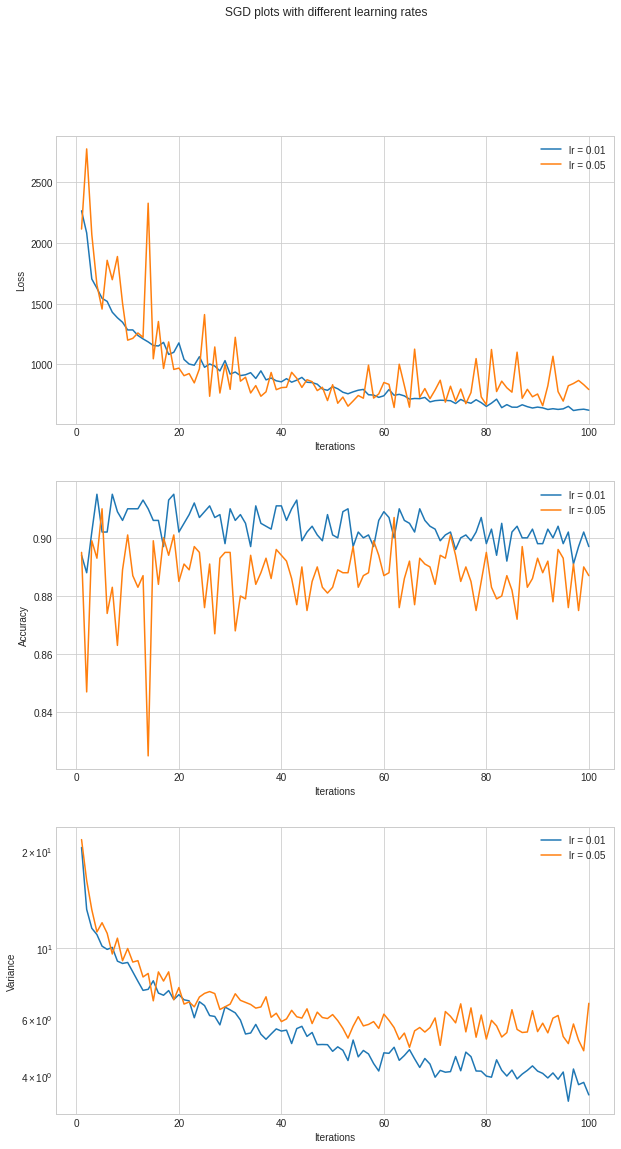

In [ ]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(3, figsize = (10, 18))
fig.suptitle('SGD plots with different learning rates')

axs[0].plot(range(1, 101), SGD1_losses01[1:], label='lr = 0.01')
axs[0].plot(range(1, 101), SGD1_losses05[1:], label='lr = 0.05')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Iterations')
axs[0].legend()

axs[1].plot(range(1, 101), SGD1_accs01[1:], label='lr = 0.01')
axs[1].plot(range(1, 101), SGD1_accs05[1:], label='lr = 0.05')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Iterations')
axs[1].legend()

axs[2].semilogy(range(1, 101), SGD1_vars01, label='lr = 0.01')
axs[2].semilogy(range(1, 101), SGD1_vars05, label='lr = 0.05')
axs[2].set_ylabel('Variance')
axs[2].set_xlabel('Iterations')
axs[2].legend()

## Mini-Batch Gradient Descent (Batch Size = 4)

In [ ]:
SGD4_losses01, SGD4_accs01, SGD4_vars01, = SGD_optimize(0.01, 4)
SGD4_losses04, SGD4_accs04, SGD4_vars04, = SGD_optimize(0.04, 4)
SGD4_losses2, SGD4_accs2, SGD4_vars2, = SGD_optimize(0.2, 4)

Step 0: loss= 13815.89 , accuracy= 0.1
Step 1: loss= 2213.004, accuracy= 0.895, variance= 84.108
Step 2: loss= 1911.248, accuracy= 0.900, variance= 52.252
Step 3: loss= 1794.951, accuracy= 0.915, variance= 48.767
Step 4: loss= 1622.915, accuracy= 0.906, variance= 42.731
Step 5: loss= 1535.633, accuracy= 0.914, variance= 37.847
Step 6: loss= 1447.106, accuracy= 0.913, variance= 42.484
Step 7: loss= 1461.165, accuracy= 0.920, variance= 36.300
Step 8: loss= 1357.665, accuracy= 0.913, variance= 35.126
Step 9: loss= 1313.818, accuracy= 0.911, variance= 32.395
Step 10: loss= 1270.885, accuracy= 0.912, variance= 32.697
Step 11: loss= 1323.988, accuracy= 0.906, variance= 33.434
Step 12: loss= 1206.629, accuracy= 0.917, variance= 33.699
Step 13: loss= 1231.431, accuracy= 0.914, variance= 35.628
Step 14: loss= 1165.408, accuracy= 0.909, variance= 30.823
Step 15: loss= 1161.116, accuracy= 0.912, variance= 30.339
Step 16: loss= 1193.543, accuracy= 0.906, variance= 32.694
Step 17: loss= 1096.643, a

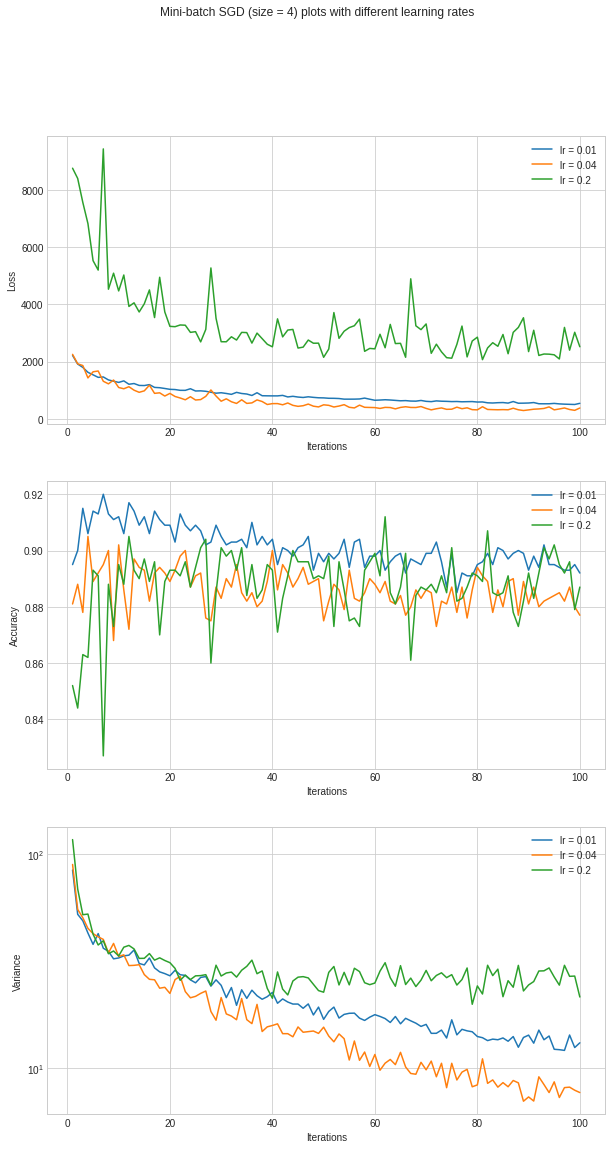

In [ ]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(3, figsize = (10, 18))
fig.suptitle('Mini-batch SGD (size = 4) plots with different learning rates')

axs[0].plot(range(1, 101), SGD4_losses01[1:], label='lr = 0.01')
axs[0].plot(range(1, 101), SGD4_losses04[1:], label='lr = 0.04')
axs[0].plot(range(1, 101), SGD4_losses2[1:], label='lr = 0.2')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Iterations')
axs[0].legend()

axs[1].plot(range(1, 101), SGD4_accs01[1:], label='lr = 0.01')
axs[1].plot(range(1, 101), SGD4_accs04[1:], label='lr = 0.04')
axs[1].plot(range(1, 101), SGD4_accs2[1:], label='lr = 0.2')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Iterations')
axs[1].legend()

axs[2].semilogy(range(1, 101), SGD4_vars01, label='lr = 0.01')
axs[2].semilogy(range(1, 101), SGD4_vars04, label='lr = 0.04')
axs[2].semilogy(range(1, 101), SGD4_vars2, label='lr = 0.2')
axs[2].set_ylabel('Variance')
axs[2].set_xlabel('Iterations')
axs[2].legend()

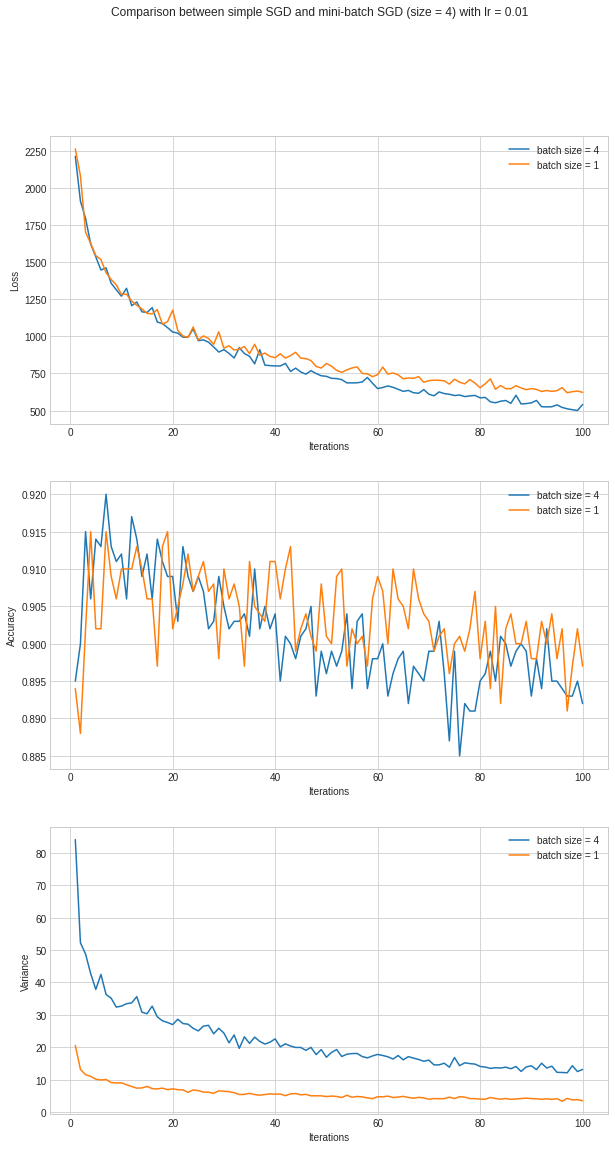

In [ ]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(3, figsize = (10, 18))
fig.suptitle('Comparison between simple SGD and mini-batch SGD (size = 4) with lr = 0.01')

axs[0].plot(range(1, 101), SGD4_losses01[1:], label='batch size = 4')
axs[0].plot(range(1, 101), SGD1_losses01[1:], label='batch size = 1')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Iterations')
axs[0].legend()

axs[1].plot(range(1, 101), SGD4_accs01[1:], label='batch size = 4')
axs[1].plot(range(1, 101), SGD1_accs01[1:], label='batch size = 1')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Iterations')
axs[1].legend()

axs[2].plot(range(1, 101), SGD4_vars01, label='batch size = 4')
axs[2].plot(range(1, 101), SGD1_vars01, label='batch size = 1')
axs[2].set_ylabel('Variance')
axs[2].set_xlabel('Iterations')
axs[2].legend()

## How Stochastic Variance Reduced Gradient (SVRG) influences optimization?

According to the [paper](https://papers.nips.cc/paper/4937-accelerating-stochastic-gradient-descent-using-predictive-variance-reduction.pdf), we know:

$$w_t = w_{t-1} - \eta_t \big(\nabla \psi_{i_t}(w_{t-1}) - \nabla \psi_{i_t}(\tilde{w}) + \nabla P(\tilde{w})\big),$$


where $\tilde{w}$ is a snapshot that is updated every $m$ iterations, $\eta_t$ is the learning rate, $\psi_{i}(w) = \mathcal{L}(w, X_i, y_i)$ and $P(w) = \sum_{i=1}^M  \psi_{i}(w)$, and $i_t$ is randomly drawn from $\{1, 2, ..., M\}$.

Let $\tilde{\mu} := \nabla P(\tilde{w})$, then the expectation of $\tilde{\mu} - \nabla \psi_{i_t}(\tilde{w})$ is zero. Thus we have

$$ \mathbb{E}[w_t|w_{t-1}] = \mathbb{E}[w_{t-1}|w_{t-1}] - \eta_t \mathbb{E}[\nabla \psi_{i_t}(w_{t-1})] - \eta_t \mathbb{E}[\tilde{\mu} - \nabla \psi_{i_t}(\tilde{w})] = w_{t-1} - \eta_t \nabla P(w_{t-1}).$$


We know that SGD is unbiased estimate of the gradient of $P$ at each step:

$$ \mathbb{E}[\nabla \psi_{i_t}(w_{t-1})] = \nabla P(w_{t-1})$$


Since $\nabla \psi_{i_t}(\tilde{w}) - \nabla \psi_{i_t}(w_{t-1}) \approx \tilde{\mu} - \nabla P(w_{t-1})$, SVRG updating rule cancels the randomness induced by random sampling $i_t$. When both $\tilde{w}$ and $w_t$ converge to the same parameter $w_∗$, then $\tilde{\mu} \rightarrow 0$ and $\nabla \psi_{i_t}(\tilde{w}) \rightarrow \nabla \psi_{i_t}(w_*)$. Therefore


$$
\nabla \psi_{i_t}(w_{t-1}) - \nabla \psi_{i_t}(\tilde{w}) + \tilde{\mu} \rightarrow \nabla \psi_{i_t}(w_{t-1}) - \nabla \psi_{i_t}(w_\ast) \rightarrow 0.
$$

This convergance to zero means variability is reduced.


We expect that when a high learning rate is used in SGD, in the beginning, training loss drops quickly, though it oscillates above the optima and never reaches it. With a small learning rate, the minimum may be approached eventually, but it will take many iterations. Thus, we need to start SGD with a large learning rate and gradually reduce it. By contrast, the learning rate for SVRG does not have to decay, and SVRG smoothly goes down faster than SGD, with relatively considerable less variance.


In [ ]:
def compute_gradients(model, gamma):
    g_W, g_b = [], []
    for i in range(len(y_train)):
        grads0, grads1 = model.gradients(X_train[i:i+1], y_train[i:i+1], gamma)
        g_W.append(grads0.numpy())
        g_b.append(grads1.numpy())

    g_W = np.stack(g_W, axis = 0)
    g_b = np.stack(g_b, axis = 0)
    return g_W, g_b, np.mean(g_W, 0), np.mean(g_b, 0)

In [ ]:
def SVRG_optimize(lambd, m):   
    model = MNIST_Model()
    gamma = 1e-4
    optimizer = SGD(lambd)
    losses = [model.loss(X_train, y_train, gamma)]
    accs = [model.accuracy(X_test, y_test)]
    vars = []
    deltas = []

    print('Step 0: loss=', losses[-1].numpy(), ', accuracy=', accs[-1].numpy())

    for s in range(100):
        g_W, g_b, mu_W, mu_b = compute_gradients(model, gamma)

        for t in range(m):
            i = np.random.choice(M, 1)
            delta = model.SVRG(X_train[i], y_train[i], gamma, g_W[i[0]], g_b[i[0]], mu_W, mu_b, optimizer)
            deltas.append(delta)

        losses.append(model.loss(X_train, y_train, gamma))
        accs.append(model.accuracy(X_test, y_test))
        vars.append(compute_variance(deltas))
        deltas = []

        print('Step {0}: loss= {1:0.3f}, accuracy= {2:0.3f}, variance= {3:0.3f}'.format(
            s+1, losses[-1].numpy(), accs[-1].numpy(), vars[-1].numpy()))
    
    return losses, accs, vars

In [ ]:
SVRG_losses01, SVRG_accs01, SVRG_vars01 = SVRG_optimize(0.01, M)
SVRG_losses05, SVRG_accs05, SVRG_vars05 = SVRG_optimize(0.05, M)

Step 0: loss= 13815.89 , accuracy= 0.1
Step 1: loss= 2408.154, accuracy= 0.884, variance= 48.644
Step 2: loss= 1809.885, accuracy= 0.918, variance= 1.917
Step 3: loss= 1617.896, accuracy= 0.919, variance= 0.216
Step 4: loss= 1509.615, accuracy= 0.920, variance= 0.052
Step 5: loss= 1431.341, accuracy= 0.917, variance= 0.019
Step 6: loss= 1369.128, accuracy= 0.917, variance= 0.010
Step 7: loss= 1317.852, accuracy= 0.918, variance= 0.006
Step 8: loss= 1273.705, accuracy= 0.915, variance= 0.005
Step 9: loss= 1235.374, accuracy= 0.915, variance= 0.003
Step 10: loss= 1201.171, accuracy= 0.917, variance= 0.004
Step 11: loss= 1170.558, accuracy= 0.916, variance= 0.002
Step 12: loss= 1142.830, accuracy= 0.915, variance= 0.001
Step 13: loss= 1117.514, accuracy= 0.915, variance= 0.001
Step 14: loss= 1094.175, accuracy= 0.914, variance= 0.001
Step 15: loss= 1072.596, accuracy= 0.914, variance= 0.001
Step 16: loss= 1052.544, accuracy= 0.914, variance= 0.001
Step 17: loss= 1033.792, accuracy= 0.915,

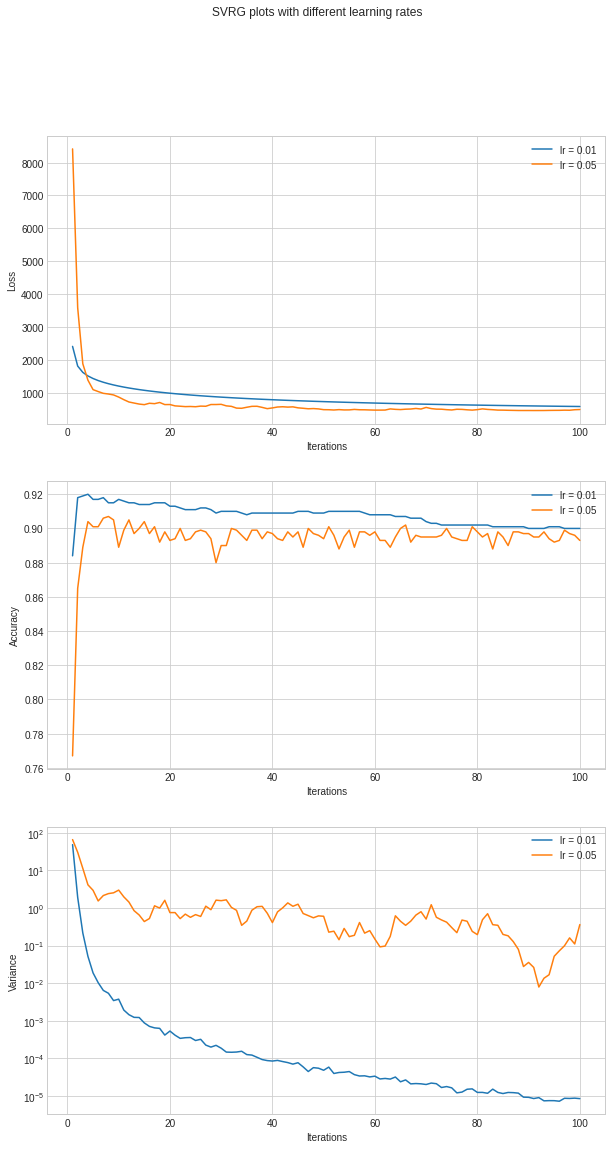

In [ ]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(3, figsize = (10, 18))
fig.suptitle('SVRG plots with different learning rates')

axs[0].plot(range(1, 101), SVRG_losses01[1:], label='lr = 0.01')
axs[0].plot(range(1, 101), SVRG_losses05[1:], label='lr = 0.05')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Iterations')
axs[0].legend()

axs[1].plot(range(1, 101), SVRG_accs01[1:], label='lr = 0.01')
axs[1].plot(range(1, 101), SVRG_accs05[1:], label='lr = 0.05')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Iterations')
axs[1].legend()

axs[2].semilogy(range(1, 101), SVRG_vars01, label='lr = 0.01')
axs[2].semilogy(range(1, 101), SVRG_vars05, label='lr = 0.05')
axs[2].set_ylabel('Variance')
axs[2].set_xlabel('Iterations')
axs[2].legend()

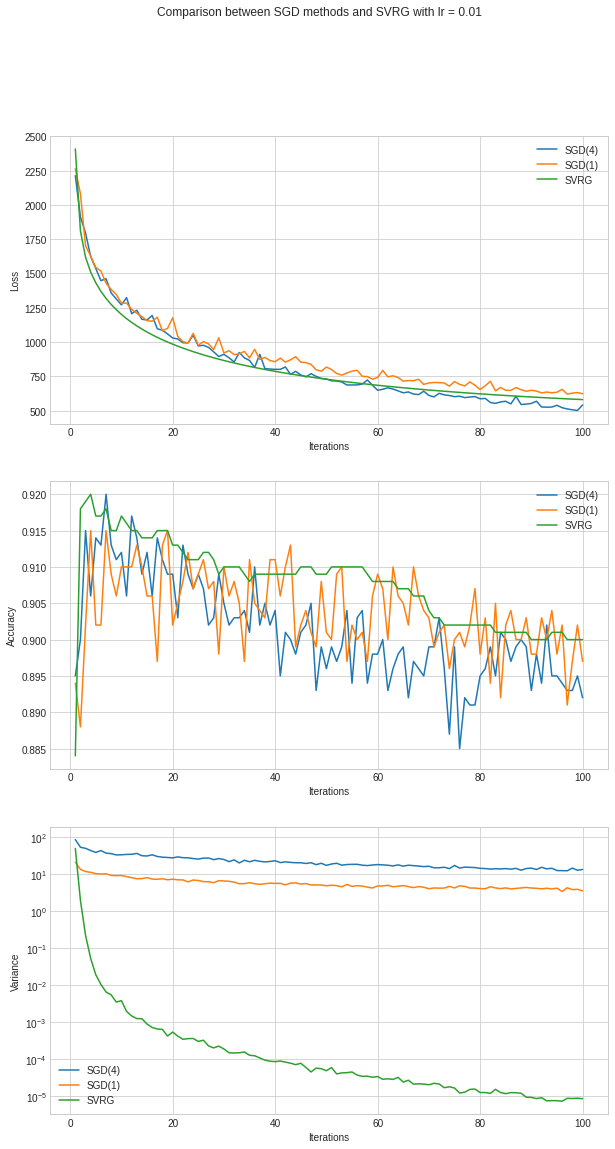

In [ ]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(3, figsize = (10, 18))
fig.suptitle('Comparison between SGD methods and SVRG with lr = 0.01')

axs[0].plot(range(1, 101), SGD4_losses01[1:], label='SGD(4)')
axs[0].plot(range(1, 101), SGD1_losses01[1:], label='SGD(1)')
axs[0].plot(range(1, 101), SVRG_losses01[1:], label='SVRG')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Iterations')
axs[0].legend()

axs[1].plot(range(1, 101), SGD4_accs01[1:], label='SGD(4)')
axs[1].plot(range(1, 101), SGD1_accs01[1:], label='SGD(1)')
axs[1].plot(range(1, 101), SVRG_accs01[1:], label='SVRG')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Iterations')
axs[1].legend()

axs[2].semilogy(range(1, 101), SGD4_vars01, label='SGD(4)')
axs[2].semilogy(range(1, 101), SGD1_vars01, label='SGD(1)')
axs[2].semilogy(range(1, 101), SVRG_vars01, label='SVRG')
axs[2].set_ylabel('Variance')
axs[2].set_xlabel('Iterations')
axs[2].legend()

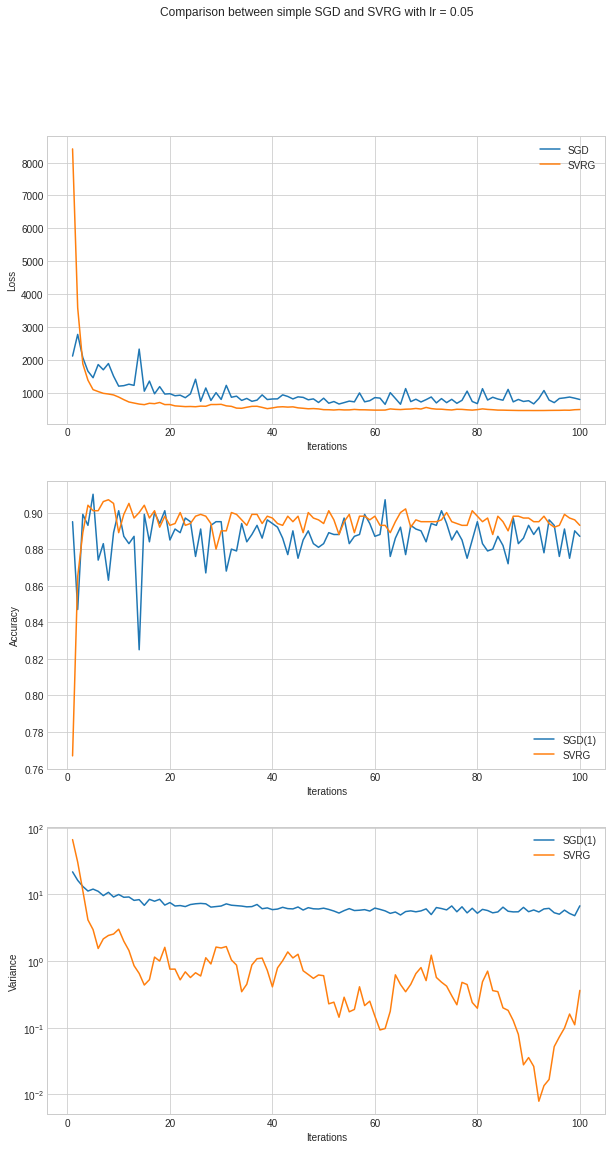

In [ ]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(3, figsize = (10, 18))
fig.suptitle('Comparison between simple SGD and SVRG with lr = 0.05')

axs[0].plot(range(1, 101), SGD1_losses05[1:], label='SGD')
axs[0].plot(range(1, 101), SVRG_losses05[1:], label='SVRG')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Iterations')
axs[0].legend()

axs[1].plot(range(1, 101), SGD1_accs05[1:], label='SGD(1)')
axs[1].plot(range(1, 101), SVRG_accs05[1:], label='SVRG')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Iterations')
axs[1].legend()

axs[2].semilogy(range(1, 101), SGD1_vars05, label='SGD(1)')
axs[2].semilogy(range(1, 101), SVRG_vars05, label='SVRG')
axs[2].set_ylabel('Variance')
axs[2].set_xlabel('Iterations')
axs[2].legend()

## Conclusion

By decreasing $m$, the number of stages for convergence increases, so we need to compute $\nabla P(\tilde{w})$ more frequently, leading to the more average time taken per iteration. However, for relatively large $m$, there would be bigger gaps between $\tilde{w}$ and $w$, which could reduce the algorithm's effect on variance reduction. Since every stage requires $2m + M$ gradient computations, it is natural to choose $m$ to be the same order of $M$.

Here is a summary of the pros and cons of SVRG:

**Pros:**


Reducing the stochastic gradient variance enables us to use a constant learning rate and obtains linear convergence in expectation. This is in contrast with SGD, which its randomness causes the gradient variance, leading to decay learning rate and sub-linear convergence rate.

This variance reduction method also applies to nonconvex optimization problems, such as training deep neural networks.

**Cons:**


In SVRG, the average number of gradient calculations per iteration increases (because of computing $\nabla P(\tilde{w})$). This could be computationally expensive when $M$ is large and significantly raises the average time of every step.

